# Pairwise DTW Distance Between Gesture Barycenters

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tslearn.metrics import dtw
from tslearn.barycenters import dtw_barycenter_averaging
from collections import defaultdict
import sys

In [10]:
def extract_sequences(df):
    sequences = defaultdict(list)
    for (user, gesture, sequence_id), group in df.groupby(['user', 'gesture', 'sequence']):
        sequence_data = group[['x', 'y', 'z']].to_numpy()
        sequence_data -= np.mean(sequence_data, axis=0)
        sequences[(user, gesture)].append(sequence_data)
    return sequences

In [11]:
def compute_gesture_barycenters(sequences):
    gesture_groups = defaultdict(list)
    for (user, gesture), seq_list in sequences.items():
        gesture_groups[gesture].extend(seq_list)

    gesture_barycenters = {}
    for gesture, seqs in gesture_groups.items():
        min_len = min(seq.shape[0] for seq in seqs)
        aligned_seqs = [seq[:min_len] for seq in seqs]
        barycenter = dtw_barycenter_averaging(aligned_seqs)
        gesture_barycenters[gesture] = barycenter
    return gesture_barycenters

In [7]:
def print_pairwise_dtw_distances(gesture_barycenters):
    gestures = sorted(gesture_barycenters.keys())
    for i in range(len(gestures)):
        for j in range(i + 1, len(gestures)):
            g1, g2 = gestures[i], gestures[j]
            seq1 = gesture_barycenters[g1]
            seq2 = gesture_barycenters[g2]
            dist = dtw(seq1, seq2)
            print(f"distance between {g1} {g2} = {int(dist)}")
            sys.stdout.flush()

## 🧪 Usage Example
Replace `'your_dataset.csv'` with the actual path to your gesture dataset.

In [8]:
# Load your gesture dataset
df = pd.read_csv(r"C:\Users\RS10\Downloads\Standardize.csv")  # Make sure this file exists!

# Run the full pipeline
sequences = extract_sequences(df)
gesture_barycenters = compute_gesture_barycenters(sequences)
print_pairwise_dtw_distances(gesture_barycenters)

distance between 0 1 = 5
distance between 0 2 = 5
distance between 0 3 = 5
distance between 0 4 = 5
distance between 0 5 = 3
distance between 0 6 = 3
distance between 0 7 = 4
distance between 0 8 = 4
distance between 0 9 = 4
distance between 1 2 = 2
distance between 1 3 = 3
distance between 1 4 = 9
distance between 1 5 = 5
distance between 1 6 = 5
distance between 1 7 = 4
distance between 1 8 = 6
distance between 1 9 = 5
distance between 2 3 = 1
distance between 2 4 = 9
distance between 2 5 = 6
distance between 2 6 = 6
distance between 2 7 = 2
distance between 2 8 = 7
distance between 2 9 = 6
distance between 3 4 = 11
distance between 3 5 = 7
distance between 3 6 = 6
distance between 3 7 = 1
distance between 3 8 = 6
distance between 3 9 = 6
distance between 4 5 = 8
distance between 4 6 = 7
distance between 4 7 = 10
distance between 4 8 = 8
distance between 4 9 = 7
distance between 5 6 = 1
distance between 5 7 = 7
distance between 5 8 = 4
distance between 5 9 = 2
distance between 6 7 = 

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

def evaluate_user_independent_with_conf_matrix(sequences, k=1):
    users = sorted(set(u for u, _ in sequences.keys()))
    accuracies = []
    all_y_true, all_y_pred = [], []

    for test_user in tqdm(users, desc="User-Independent CV"):
        train = {k: v for k, v in sequences.items() if k[0] != test_user}
        test = {k: v for k, v in sequences.items() if k[0] == test_user}

        y_true, y_pred = [], []

        for (user, true_gesture), gesture_sequences in test.items():
            for test_seq in gesture_sequences:
                distances = []
                for (train_user, train_gesture), train_sequences in train.items():
                    for train_seq in train_sequences:
                        dist = dtw(test_seq, train_seq)
                        distances.append((dist, train_gesture))
                distances.sort()
                nearest = [g for _, g in distances[:k]]
                predicted = max(set(nearest), key=nearest.count)
                y_true.append(true_gesture)
                y_pred.append(predicted)

        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    print("User-Independent Accuracy: {:.2f}% ± {:.2f}".format(
        100*np.mean(accuracies), 100*np.std(accuracies)))

    # Plot confusion matrix
    labels = sorted(set(all_y_true + all_y_pred))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix (User-Independent CV)")
    plt.show()

    return accuracies

User-Independent CV: 100%|██████████| 10/10 [01:46<00:00, 10.61s/it]

User-Independent Accuracy: 96.70% ± 3.69


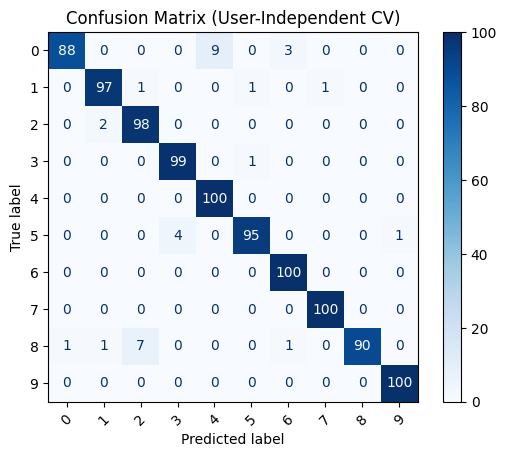

[0.94, 0.89, 1.0, 0.99, 0.93, 0.99, 1.0, 0.99, 1.0, 0.94]

In [15]:
sequences = extract_sequences(df)

evaluate_user_independent_with_conf_matrix(sequences, k=1)

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

def evaluate_user_dependent_with_conf_matrix(sequences, k=1, n_splits=5):
    users = sorted(set(u for u, _ in sequences.keys()))
    accuracies = []
    all_y_true, all_y_pred = [], []

    for user in tqdm(users, desc="User-Dependent CV"):
        user_data = {k: v for k, v in sequences.items() if k[0] == user}

        # Flatten (gesture, sequence)
        flat_sequences = []
        for (u, gesture), seq_list in user_data.items():
            for seq in seq_list:
                flat_sequences.append((gesture, seq))

        if len(flat_sequences) < n_splits:
            continue

        gestures = np.array([g for g, _ in flat_sequences])
        data = np.array([s for _, s in flat_sequences], dtype=object)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_idx, test_idx in kf.split(data):
            X_train, X_test = data[train_idx], data[test_idx]
            y_train, y_test = gestures[train_idx], gestures[test_idx]

            y_pred = []
            for test_seq in X_test:
                distances = []
                for train_seq, train_gesture in zip(X_train, y_train):
                    dist = dtw(test_seq, train_seq)
                    distances.append((dist, train_gesture))
                distances.sort()
                nearest = [g for _, g in distances[:k]]
                predicted = max(set(nearest), key=nearest.count)
                y_pred.append(predicted)

            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)

    if len(all_y_true) == 0:
        print("No predictions to display. Not enough data?")
        return accuracies

    print("User-Dependent Accuracy: {:.2f}% ± {:.2f}".format(
        100 * np.mean(accuracies), 100 * np.std(accuracies)))

    # Plot confusion matrix
    labels = sorted(set(all_y_true + all_y_pred))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Oranges")
    plt.title("Confusion Matrix (User-Dependent CV)")
    plt.show()

    return accuracies

User-Dependent CV: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

User-Dependent Accuracy: 99.70% ± 0.91


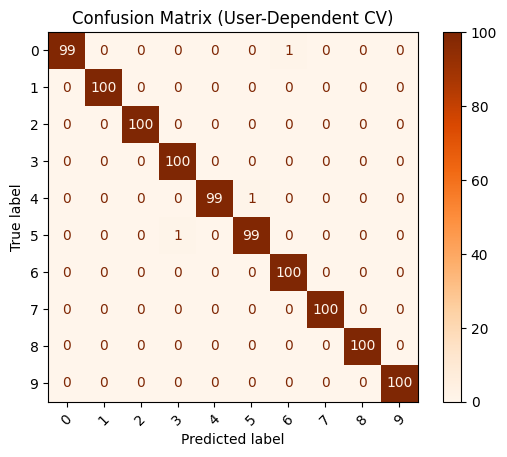

[1.0,
 0.9696969696969697,
 1.0,
 1.0,
 0.9696969696969697,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9696969696969697,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [17]:
sequences = extract_sequences(df)

evaluate_user_dependent_with_conf_matrix(sequences, k=1, n_splits=3)